In [75]:
import numpy as np
import pandas as pd
import statsmodels
import scipy as sc
from statsmodels.stats.weightstats import *
from pandas.tools.plotting import scatter_matrix
from scipy import stats
from collections import namedtuple
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
data = pd.read_csv('ab_browser_test.csv')

In [7]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [19]:
clicks_exp = data[data['slot'] == 'exp']['n_clicks'].values
clicks_ctl = data[data['slot'] == 'control']['n_clicks'].values

In [36]:
data[data['slot'] == 'exp']['n_clicks'].describe()

count    281580.000000
mean         11.584001
std          20.219494
min           0.000000
25%           1.000000
50%           5.000000
75%          13.000000
max         776.000000
Name: n_clicks, dtype: float64

In [37]:
data[data['slot'] == 'control']['n_clicks'].describe()

count    284554.000000
mean         11.280906
std          20.282018
min           0.000000
25%           1.000000
50%           4.000000
75%          13.000000
max         863.000000
Name: n_clicks, dtype: float64

In [43]:
print clicks_exp.mean(), np.median(clicks_exp)
print clicks_ctl.mean(), np.median(clicks_ctl)

11.5840009944 5.0
11.2809062603 4.0


In [20]:
s1 = sum(clicks_exp)
s2 = sum(clicks_ctl)
100* (s1 - s2) / float(s2)

1.6135689824415806

In [29]:
def iter_bootstrap_samples(data, n_samples):
    i = 0
    while i < n_samples:
        indices = np.random.randint(0, len(data), len(data))
        sample = data[indices]
        yield sample
        i += 1

In [30]:
def get_bootstrap_samples2(data, n_samples, func):
    scores = []
    for sample in iter_bootstrap_samples(data, n_samples):
        scores.append(func(sample))
    return scores

In [46]:
def get_square_diff(sample, m):    
    res = 0
    for n in sample:
        res += (n-m)**2
    return res

In [47]:
def get_bootstrap_samples3(data, n_samples):
    means = []
    squares = []
    for sample in iter_bootstrap_samples(data, n_samples):
        m = sample.mean()
        means.append(m)
        squares.append(get_square_diff(sample, m))
        
    return (means, squares)

In [21]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [22]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [34]:
np.random.seed(0)
#exp_median_scores = map(np.median, get_bootstrap_samples(clicks_exp, 300))
#ctl_median_scores = map(np.median, get_bootstrap_samples(clicks_ctl, 300))
exp_median_scores = get_bootstrap_samples2(clicks_exp, 500, np.median)
ctl_median_scores = get_bootstrap_samples2(clicks_ctl, 500, np.median)
delta_median_scores = map(lambda x: x[0] - x[1], zip(exp_median_scores, ctl_median_scores))
interval = stat_intervals(delta_median_scores, 0.05)
interval[0], interval[1]


(1.0, 1.0)

In [35]:
# exp_mean_scores = map(np.mean, get_bootstrap_samples(clicks_exp, 400))
# ctl_mean_scores = map(np.mean, get_bootstrap_samples(clicks_ctl, 400))
exp_mean_scores = get_bootstrap_samples2(clicks_exp, 500, np.mean)
ctl_mean_scores = get_bootstrap_samples2(clicks_ctl, 500, np.mean)
delta_mean_scores = map(lambda x: x[0] - x[1], zip(exp_median_scores, ctl_median_scores))
interval = stat_intervals(delta_mean_scores, 0.05)
interval[0], interval[1]

(1.0, 1.0)

Проверим нормальность

In [44]:
print "Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(clicks_exp)

Shapiro-Wilk normality test, W-statistic: 0.545756, p-value: 0.000000


/home/astar/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:1329: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


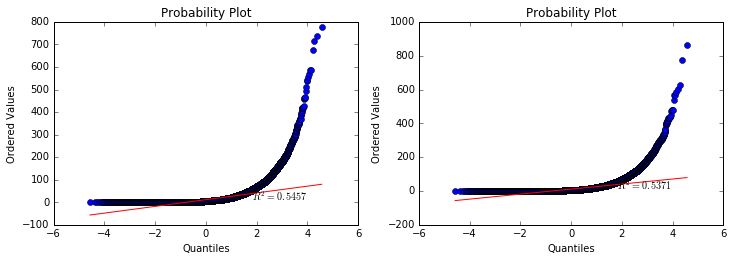

In [45]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(clicks_exp, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(clicks_ctl, dist="norm", plot=pylab)
pylab.show()

In [48]:
np.random.seed(0)
n_boot_samples = 500
means, squares = get_bootstrap_samples3(clicks_ctl, n_boot_samples)

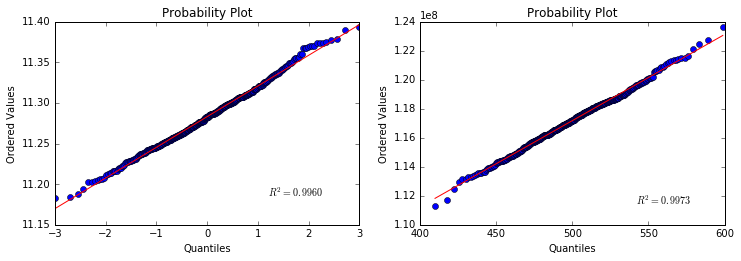

In [50]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(means, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(squares, dist="chi2", sparams=(len(squares)-1), plot=pylab)
pylab.show()
#print r1, r2

r1^2 = 0.9960

r2^2 = 0.9973

In [76]:
clicks_ctl2 = data[data['slot']=='control'].groupby(by='userID')['n_clicks'].agg(np.sum).values
clicks_exp2 = data[data['slot']=='exp'].groupby(by='userID')['n_clicks'].agg(np.sum).values

In [77]:
clicks_ctl2.mean(), clicks_exp2.mean()

(11.287332273762974, 11.589351572215314)

In [78]:
stats.mannwhitneyu(clicks_ctl2, clicks_exp2)

MannwhitneyuResult(statistic=38901259929.0, pvalue=nan)

In [79]:
MannwhitneyuResult = namedtuple('MannwhitneyuResult', ('statistic', 'pvalue'))
def tiecorrect(rankvals):
    arr = np.sort(rankvals)
    idx = np.nonzero(np.r_[True, arr[1:] != arr[:-1], True])[0]
    cnt = np.diff(idx).astype(np.float64)
    size = np.float64(arr.size)
    return 1.0 if size < 2 else 1.0 - (cnt**3 - cnt).sum() / (size**3 - size)

def mannwhitneyu(x, y, use_continuity=True, alternative=None):
    if alternative is None:
        warnings.warn("Calling `mannwhitneyu` without specifying "
                      "`alternative` is deprecated.", DeprecationWarning)

    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)
    ranked = sc.stats.rankdata(np.concatenate((x, y)))
    rankx = ranked[0:n1]  # get the x-ranks
    u1 = n1*n2 + (n1*(n1+1))/2.0 - np.sum(rankx, axis=0)  # calc U for x
    u2 = n1*n2 - u1  # remainder is U for y
    T = tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in mannwhitneyu')
    sd = np.sqrt(T * n1 * n2 * (n1+n2+1) / 12.0)

    meanrank = n1*n2/2.0 + 0.5 * use_continuity
    if alternative is None or alternative == 'two-sided':
        bigu = max(u1, u2)
    elif alternative == 'less':
        bigu = u1
    elif alternative == 'greater':
        bigu = u2
    else:
        raise ValueError("alternative should be None, 'less', 'greater' "
                         "or 'two-sided'")
    z = (bigu - meanrank) / sd
    if alternative is None:
        # This behavior, equal to half the size of the two-sided
        # p-value, is deprecated.
        p = sc.stats.distributions.norm.sf(abs(z))
    elif alternative == 'two-sided':
        p = 2 * sc.stats.distributions.norm.sf(abs(z))
    else:
        p = sc.stats.distributions.norm.sf(z)
    u = u2
    # This behavior is deprecated.
    if alternative is None:
        u = min(u1, u2)
    return MannwhitneyuResult(u, p)

In [80]:
mannwhitneyu(clicks_ctl2, clicks_exp2)

/home/astar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.


MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604388e-75)

In [74]:
data.browser.value_counts()

Browser #4     156833
Browser #22    142905
Browser #2     110737
Browser #14     89123
Browser #20     33929
Browser #17     32607
Name: browser, dtype: int64

In [86]:
data[(data['slot']=='control') & (data['browser']=='Browser #22')].groupby(by='userID')['n_clicks'].agg(np.sum).values

array([36, 72,  1, ...,  4,  1,  1], dtype=int64)

In [92]:
pvalues = []
for browser in ['Browser #4', 'Browser #22', 'Browser #2', 'Browser #14', 'Browser #20', 'Browser #17']:
    ctl = data[(data['slot']=='control') & (data['browser']==browser)].groupby(by='userID')['n_clicks'].agg(np.sum).values
    exp = data[(data['slot']=='exp') & (data['browser']==browser)].groupby(by='userID')['n_clicks'].agg(np.sum).values
    p = mannwhitneyu(ctl, exp).pvalue
    pvalues.append(p)
    
reject, p_corrected, a1, a2 = multipletests(pvalues, 
                                            alpha = 0.05, 
                                            method = 'holm')
print pvalues
print p_corrected
print reject

/home/astar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.


[0.40760617658454984, 0.25740551522100324, 0.027243860419724104, 0.0, 0.45366656388735377, 0.037400601430108024]
[ 0.81521235  0.77221655  0.1362193   0.          0.81521235  0.14960241]
[False False False  True False False]


In [94]:
pvalues = []
for browser in ['Browser #4', 'Browser #22', 'Browser #2', 'Browser #14', 'Browser #20', 'Browser #17']:
    ctl = data[(data['slot']=='control') & (data['browser']==browser)]['n_clicks'].values
    exp = data[(data['slot']=='exp') & (data['browser']==browser)]['n_clicks'].values
    p = mannwhitneyu(ctl, exp).pvalue
    pvalues.append(p)
    
reject, p_corrected, a1, a2 = multipletests(pvalues, 
                                            alpha = 0.05, 
                                            method = 'holm')
print pvalues
print p_corrected
print reject

/home/astar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.


[0.40760617658454984, 0.25740551522100324, 0.027243860419724104, 0.0, 0.45366656388735377, 0.037400601430108024]
[ 0.81521235  0.77221655  0.1362193   0.          0.81521235  0.14960241]
[False False False  True False False]


In [91]:

for browser in ['Browser #4', 'Browser #22', 'Browser #2', 'Browser #14', 'Browser #20', 'Browser #17']:
    s1 = sum(data[(data['slot']=='control') & (data['browser']==browser)]['n_nonclk_queries'].values)
    s2 = sum(data[(data['slot']=='control') & (data['browser']==browser)]['n_queries'].values)
    p1 = 100 * s1 / float(s2)
    s3 = sum(data[(data['slot']=='exp') & (data['browser']==browser)]['n_nonclk_queries'].values)
    s4 = sum(data[(data['slot']=='exp') & (data['browser']==browser)]['n_queries'].values)
    p2 = 100 * s3 / float(s4)
    print browser, p1, p2

Browser #4 46.9709296351 45.1429419036
Browser #22 40.5939765935 39.8539472197
Browser #2 45.9627471792 44.9827469486
Browser #14 57.5904113601 43.7556173613
Browser #20 40.5404847434 38.9773764837
Browser #17 36.2993667463 36.9374128487
